In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

path = '/content/drive/MyDrive/FA-KES/FA-KES-Dataset.csv'

df = pd.read_csv(path, encoding= 'unicode_escape')
df.head(5)


Mounted at /content/drive


,unit_id,article_title,article_content,source,date,location,labels
0,1914947530,Syria attack symptoms consistent with nerve ag...,Wed 05 Apr 2017 Syria attack symptoms consiste...,nna,4/5/2017,idlib,0
1,1914947532,Homs governor says U.S. attack caused deaths b...,Fri 07 Apr 2017 at 0914 Homs governor says U.S...,nna,4/7/2017,homs,0
2,1914947533,Death toll from Aleppo bomb attack at least 112,Sun 16 Apr 2017 Death toll from Aleppo bomb at...,nna,4/16/2017,aleppo,0
3,1914947534,Aleppo bomb blast kills six Syrian state TV,Wed 19 Apr 2017 Aleppo bomb blast kills six Sy...,nna,4/19/2017,aleppo,0
4,1914947535,29 Syria Rebels Dead in Fighting for Key Alepp...,Sun 10 Jul 2016 29 Syria Rebels Dead in Fighti...,nna,7/10/2016,aleppo,0


In [ ]:
print(df.shape)
df.isna().sum()

(804, 7)


unit_id            0
article_title      0
article_content    0
source             0
date               0
location           0
labels             0
dtype: int64

,article_title,labels
0,MSF Syrian Regime Used Chemical Weapons in Hama,1
1,Airstrikes on clinic kill 5 medics in Syrias A...,1
2,ISIL terrorists execute 50 captive Syrian troo...,0
3,Rebel shelling kills four civilians in Damascu...,0
4,Terrorist Attack Kills Two Injures Three in Al...,0
...,...,...
799,Russia: Terrorists breached cessation of hosti...,0
800,Seven dead 20 wounded in central Damascus blas...,1
801,US-led coalition airstrike kills 18 partner fo...,1
802,Blast at Syria-Turkey border kills 20 rebels M...,1


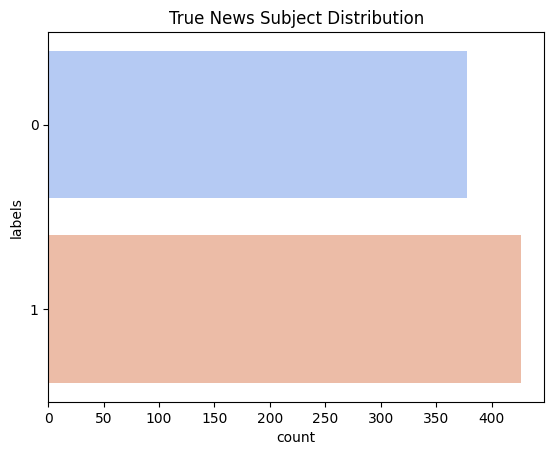

In [ ]:
from sklearn.utils import shuffle

df = df[['article_title','labels']]

# Shuffle
df = shuffle(df).reset_index(drop=True)

display(df)
sns.countplot(y="labels", palette="coolwarm", data=df).set_title('True News Subject Distribution')
plt.show()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 804 entries, 0 to 803
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   article_title  804 non-null    object
 1   labels         804 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 12.7+ KB


In [ ]:
df.drop_duplicates(subset=['article_title'],keep='first',inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 774 entries, 0 to 803
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   article_title  774 non-null    object
 1   labels         774 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 18.1+ KB


In [ ]:
train_val_df = df.sample(frac = 0.8)
test_df = df.drop(train_val_df.index)

train_df = train_val_df.sample(frac = 0.875)
val_df = train_val_df.drop(train_df.index)

# Reset Index
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print('trainset size:', train_df.shape)
print('valset size:', val_df.shape)
print('testset size:', test_df.shape)

trainset size: (542, 2)
valset size: (77, 2)
testset size: (155, 2)


In [ ]:
train_df.to_csv('train.tsv', sep='\t', index=False)
val_df.to_csv('val.tsv', sep='\t', index=False)
test_df.to_csv('test.tsv', sep='\t', index=False)

In [ ]:
!pip install transformers
import torch
from transformers import BertTokenizer
PRETRAINED_MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 80.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 114.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 26.4 MB/s eta 0:00:00


In [ ]:
from torch.utils.data import Dataset

class FakeNewsDataset(Dataset):
    def __init__(self, mode, tokenizer):
        assert mode in ['train', 'val', 'test']
        self.mode = mode
        self.df = pd.read_csv(mode + '.tsv', sep='\t').fillna("")
        self.len = len(self.df)
        self.tokenizer = tokenizer  # BERT tokenizer

    def __getitem__(self, idx):
        if self.mode == 'test':
            statement, label = self.df.iloc[idx, :].values
            label_tensor = torch.tensor(label)
        else:
            statement, label = self.df.iloc[idx, :].values
            label_tensor = torch.tensor(label)

        word_pieces = ['[CLS]']
        statement = self.tokenizer.tokenize(statement)
        word_pieces += statement + ['[SEP]']
        len_st = len(word_pieces)

        ids = self.tokenizer.convert_tokens_to_ids(word_pieces)
        tokens_tensor = torch.tensor(ids)

        segments_tensor = torch.tensor([0] * len_st, dtype=torch.long)
        
        return (tokens_tensor, segments_tensor, label_tensor)
    
    def __len__(self):
        return self.len
    
    
# Initialize Datasets for Transformation
trainset = FakeNewsDataset('train', tokenizer=tokenizer)
valset = FakeNewsDataset('val', tokenizer=tokenizer)
testset = FakeNewsDataset('test', tokenizer=tokenizer)

print('trainset size:' ,trainset.__len__())
print('valset size:',valset.__len__())
print('testset size: ',testset.__len__())

trainset size: 542
valset size: 77
testset size:  155


In [ ]:
sample_idx = 0

statement, label = trainset.df.iloc[sample_idx].values

tokens_tensor, segments_tensor, label_tensor = trainset[sample_idx]

tokens = tokenizer.convert_ids_to_tokens(tokens_tensor.tolist())
combined_text = " ".join(tokens)

print(f"""
original_statement: 
{statement}

tokens: 
{tokens}

label: {label}

--------------------

tokens_tensor: 
{tokens_tensor}

segments_tensor: 
{segments_tensor}

label_tensor: 
{label_tensor}

""")


original_statement: 
8 Civilians Killed in Terrorist Attacks in Damascus Aleppo

tokens: 
['[CLS]', '8', 'civilians', 'killed', 'in', 'terrorist', 'attacks', 'in', 'damascus', 'aleppo', '[SEP]']

label: 1

--------------------

tokens_tensor: 
tensor([  101,  1022,  9272,  2730,  1999,  9452,  4491,  1999, 16094, 22973,
          102])

segments_tensor: 
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

label_tensor: 
1




In [ ]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

def create_mini_batch(samples):
    tokens_tensors = [s[0] for s in samples]
    segments_tensors = [s[1] for s in samples]

    if samples[0][2] is not None:
        label_ids = torch.stack([s[2] for s in samples])
    else:
        label_ids = None
    
    # Zero Padding
    tokens_tensors = pad_sequence(tokens_tensors, batch_first=True)
    segments_tensors = pad_sequence(segments_tensors, batch_first=True)

    masks_tensors = torch.zeros(tokens_tensors.shape, dtype=torch.long)
    masks_tensors = masks_tensors.masked_fill(tokens_tensors != 0, 1)
    
    return tokens_tensors, segments_tensors, masks_tensors, label_ids


BATCH_SIZE = 16
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, collate_fn=create_mini_batch)
valloader = DataLoader(valset, batch_size=BATCH_SIZE, collate_fn=create_mini_batch)
testloader = DataLoader(testset, batch_size=BATCH_SIZE,collate_fn=create_mini_batch)

In [ ]:
data = next(iter(trainloader))

tokens_tensors, segments_tensors, masks_tensors, label_ids = data

In [ ]:
from transformers import BertForSequenceClassification
from IPython.display import display, clear_output

PRETRAINED_MODEL_NAME = "bert-base-uncased"
NUM_LABELS = 2

model = BertForSequenceClassification.from_pretrained(
    PRETRAINED_MODEL_NAME, num_labels=NUM_LABELS)

clear_output()

In [ ]:
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
import time

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)
model = model.to(device)

model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
NUM_EPOCHS = 3
start_time = time.time()
for epoch in range(NUM_EPOCHS):
    train_loss = 0.0
    train_acc = 0.0

    loop = tqdm(trainloader)
    for batch_idx, data in enumerate(loop):
        tokens_tensors, segments_tensors, masks_tensors, labels = [t.to(device) for t in data]

        optimizer.zero_grad()
        
        outputs = model(input_ids=tokens_tensors, 
                        token_type_ids=segments_tensors, 
                        attention_mask=masks_tensors, 
                        labels=labels)
        loss = outputs[0]
        loss.backward()
        optimizer.step()

        logits = outputs[1]
        _, pred = torch.max(logits.data, 1)
        train_acc = accuracy_score(pred.cpu().tolist() , labels.cpu().tolist())

        train_loss += loss.item()

        loop.set_description(f"Epoch [{epoch+1}/{NUM_EPOCHS}]")
        loop.set_postfix(acc = train_acc, loss = train_loss)

end_time = time.time()
training_time = end_time - start_time

device: cuda:0


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

In [ ]:
torch.save(model, './best_model.pth')

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from imblearn.metrics import geometric_mean_score
true=[]
predictions=[]
start_time = time.time()
with torch.no_grad():
    model.eval()
    for data in testloader:
        if next(model.parameters()).is_cuda:
            data = [t.to(device) for t in data if t is not None]
            
        tokens_tensors, segments_tensors, masks_tensors = data[:3]
        test_outputs = model(input_ids=tokens_tensors, 
                    token_type_ids=segments_tensors, 
                    attention_mask=masks_tensors)

        logits = test_outputs[0]
        _, pred = torch.max(logits.data, 1)

        labels = data[3]
        true.extend(labels.cpu().tolist())
        predictions.extend(pred.cpu().tolist())

end_time = time.time()
inference_time = end_time - start_time
cm = confusion_matrix(true, predictions, labels=[1, 0], normalize='pred')

accuracy = accuracy_score(true, predictions)

g_mean = geometric_mean_score(true, predictions)
print("BERT Model Accuracy : ", accuracy)
print("Precision : ", precision_score(true, predictions))
print("Recall : ", recall_score(true, predictions))
print("F1 : ", f1_score(true, predictions))
print("G-mean:", g_mean)
print("Training time: ", training_time)
print("Inference time: ", inference_time)
print(classification_report(true, predictions))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake','Real'])
disp.plot()